#### Testing out Gibbs zig-zag code:

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot

In [2]:
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [3]:
d, Nobs = 20, 200
p = 1e-1
X = rand(Normal(), d, Nobs) .* rand(Binomial(1,p), d, Nobs)
X[1,:] = ones(Nobs)
ξ_true = rand(Normal(),d).* rand(Binomial(1,0.5), d)
ξ_true[1] = rand(Normal())
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] + 0. for j in 1:Nobs];
mb_size = 10
σ02 = 1

# prior = HS_prior(d, σ02)
prior = gaussian_prior_nh(d, σ02)

gaussian_prior_nh([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [4]:
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [16]:
# Sub-sampling with weights 
ϵ = 1e-2
weights = abs.(X) + ϵ
weights ./= sum(weights,2)
mb_size = 20;
gs = [wumbsampler(Nobs, mb_size, weights[i,:]) for i in 1:d]
gs_list = mbsampler_list(d,gs);

In [17]:
A = eye(d)
opf = projopf(A, 100, hyperparam_size(prior))
opt = maxa_opt(10^6)
outp = outputscheduler(opf,opt);

In [18]:
my_zz_sampler = zz_sampler(0, gs_list, linear_bound(my_model.ll, my_model.pr, gs_list))
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [19]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

1.52 mins

In [20]:
n_samples = 10^4
samples = extract_samples(outp.opf.xi_skeleton, 
                          outp.opf.bt_skeleton, 
                          outp.opf.bt_skeleton[end]/10^4);

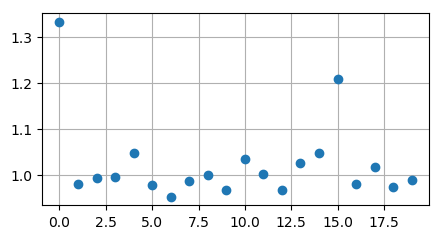

In [21]:
fig = figure("pyplot_barplot",figsize=(5,2.5))
plot([compute_configT(my_model, samples, k) for k in 1:d], "o")
grid(true)